In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random

# to get consistent results after multiple runs
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]

In [ ]:
def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  # 5.1GB
  test_url  = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"
  for i, download_link in enumerate([valid_url, train_url, test_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=temp_file, cache_dir=os.getcwd())
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(data_dir) # changed from temp_file to data_dir as get_file returns the full path

# comment the below line if you already downloaded the dataset
download_and_extract_dataset()

864538487/864538487 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
5736557430/5736557430 ━━━━━━━━━━━━━━━━━━━━ 90s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
5528640507/5528640507 ━━━━━━━━━━━━━━━━━━━━ 66s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


In [ ]:
# preparing data
# generate CSV metadata file to read img paths and labels from it
def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

# generate CSV files for all data portions, labeling nevus and seborrheic keratosis
# as 0 (benign), and melanoma as 1 (malignant)
# you should replace "data" path to your extracted dataset path
# don't replace if you used download_and_extract_dataset() function
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

Reading data/train/nevus/*
Reading data/train/seborrheic_keratosis/*
Reading data/train/melanoma/*
Saving train.csv
Reading data/valid/nevus/*
Reading data/valid/seborrheic_keratosis/*
Reading data/valid/melanoma/*
Saving valid.csv
Reading data/test/nevus/*
Reading data/test/seborrheic_keratosis/*
Reading data/test/melanoma/*
Saving test.csv


In [ ]:
# loading data
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
# load CSV files as DataFrames
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples: 2000
Number of validation samples: 150


In [ ]:
# preprocess data
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label


valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (299, 299, 3)
Label: 0


In [ ]:
# training parameters
batch_size = 64
optimizer = "rmsprop"

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

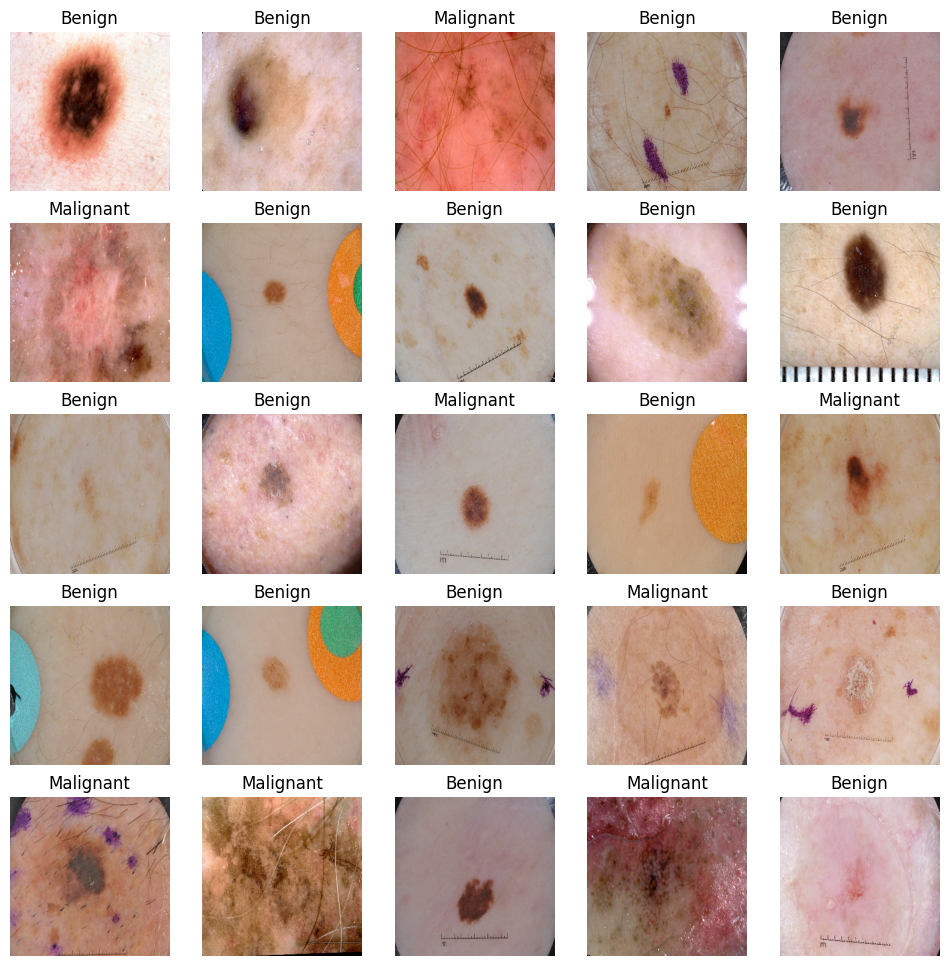

In [ ]:
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')

show_batch(batch)

In [ ]:
# building the model using tf.keras.applications.InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add a classification head
inputs = tf.keras.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
m = tf.keras.Model(inputs=inputs, outputs=outputs)

m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
# saves model checkpoint whenever we reach better weights
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds, validation_data=valid_ds,
                steps_per_epoch=n_training_samples // batch_size,
                validation_steps=n_validation_samples // batch_size, verbose=1, epochs=10,
                callbacks=[tensorboard, modelcheckpoint])

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9022 - loss: 0.2669
Epoch 1: val_loss improved from inf to 0.44450, saving model to benign-vs-malignant_64_rmsprop_0.445.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 314ms/step - accuracy: 0.8994 - loss: 0.2713 - val_accuracy: 0.8125 - val_loss: 0.4445
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9208 - loss: 0.2282
Epoch 2: val_loss improved from 0.44450 to 0.40908, saving model to benign-vs-malignant_64_rmsprop_0.409.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.9180 - loss: 0.2328 - val_accuracy: 0.8125 - val_loss: 0.4091
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9238 - loss: 0.2131
Epoch 3: val_loss did not improve from 0.40908
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - accuracy: 0.9213 - loss: 0.2175 - val_accuracy: 0.8125 - val_loss: 0.4282
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9130 - loss: 0.2311
Epoch 4: val_loss did not improve from 0.40908
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.9111 - loss: 0.2346 - val_accuracy: 0.8047 - val_loss: 0.4543
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8841 - loss: 0.2609
Epoch 5: val_loss did not improve from 0.40908
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.8825 - loss: 0.2639 - val_accuracy: 0.7578 - val_loss: 0.4678
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8804 - loss: 0.2676
Epoch 6: val_loss did not improve from 0.40908


31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.8910 - loss: 0.2631 - val_accuracy: 0.8438 - val_loss: 0.3825
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8950 - loss: 0.2595
Epoch 10: val_loss did not improve from 0.38250
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.8939 - loss: 0.2616 - val_accuracy: 0.7891 - val_loss: 0.5055


In [ ]:
# evaluation
# load testing set
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  return ds

test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of testing samples: 600


In [ ]:
# convert testing set to numpy array to fit in memory (don't do that when testing
# set is too large)
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  # print(img.shape, label.shape)
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [ ]:
# a function given a function, it predicts the class of the image
def predict_image_class(img_path, model, threshold=0.5):
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.expand_dims(img, 0) # Create a batch
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  predictions = model.predict(img)
  score = predictions.squeeze()
  if score >= threshold:
    print(f"This image is {100 * score:.2f}% malignant.")
  else:
    print(f"This image is {100 * (1 - score):.2f}% benign.")
  plt.imshow(img[0])
  plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


This image is 59.84% malignant.


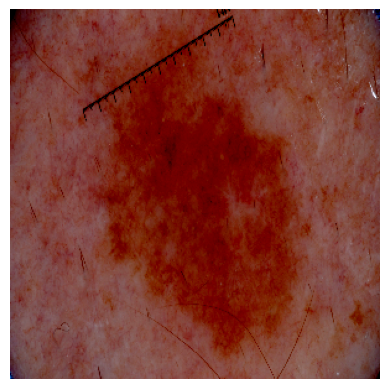

In [ ]:
predict_image_class("data/test/melanoma/ISIC_0013767.jpg", m)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


This image is 86.64% benign.


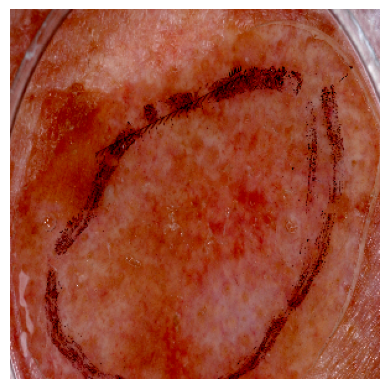

In [ ]:
predict_image_class("data/test/seborrheic_keratosis/ISIC_0012136.jpg", m)

In [ ]:
!pip install gradio -q

Loading best model from: benign-vs-malignant_64_rmsprop_0.382.h5


Test Loss: 0.4676
Test Accuracy: 0.8000
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step
Confusion Matrix:
[[438  45]
 [ 75  42]]
Sensitivity: 0.3590
Specificity: 0.9068


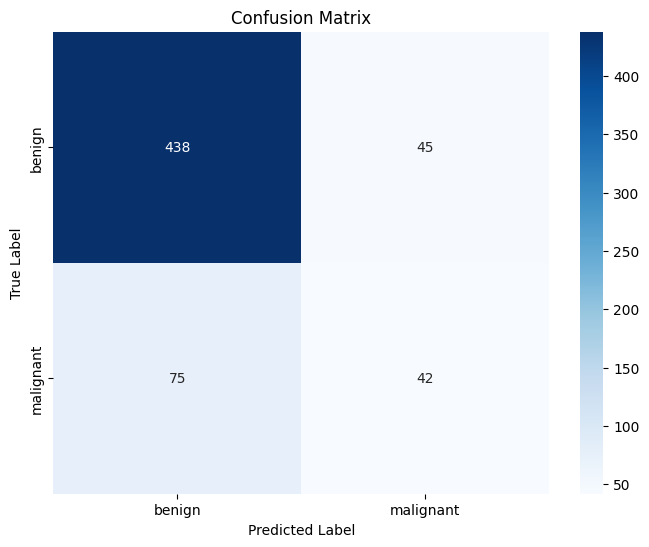

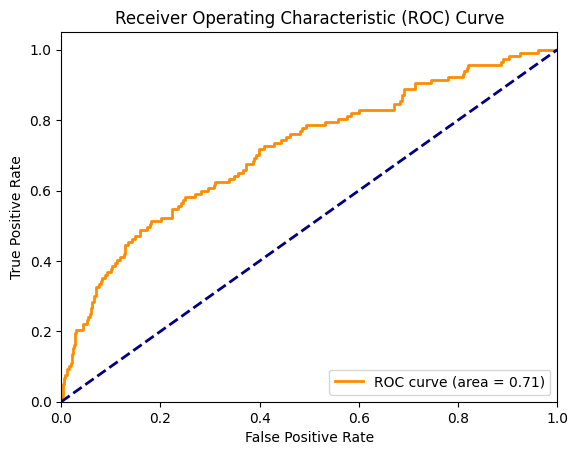

In [ ]:
# Load the best model weights based on validation loss
best_model_path = glob.glob(model_name + "*.h5")
if best_model_path:
    best_model_path.sort() # Sort to get the best model if multiple exist
    best_model_path = best_model_path[0] # Load the one with the lowest validation loss
    print(f"Loading best model from: {best_model_path}")
    m = tf.keras.models.load_model(best_model_path)

# Evaluate the model on the test set
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict on the test set and calculate metrics
y_pred = m.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Calculate confusion matrix, sensitivity, and specificity
cm = confusion_matrix(y_test, y_pred_classes)
sensitivity = sensitivity_score(y_test, y_pred_classes)
specificity = specificity_score(y_test, y_pred_classes)

print("Confusion Matrix:")
print(cm)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import gradio as gr
import matplotlib.pyplot as plt

def classify_skin_cancer(image):
    # Use the existing predict_image_class function
    # predict_image_class already handles preprocessing and plotting
    # We need to save the plot to a file to pass it to Gradio

    # Save the input image temporarily to pass its path to predict_image_class
    temp_img_path = "temp_input_image.jpg"
    plt.imsave(temp_img_path, image)

    # Run the prediction and get the classification result
    # We'll capture the printed output for the text result
    import sys
    from io import StringIO

    old_stdout = sys.stdout
    redirected_output = StringIO()
    sys.stdout = redirected_output

    # Call the prediction function, which also displays the plot
    predict_image_class(temp_img_path, m)

    sys.stdout = old_stdout

    # Get the printed classification result
    classification_result = redirected_output.getvalue().strip()

    # Gradio can display the plot directly if returned
    return classification_result, plt.gcf() # Return text and the current figure

In [ ]:
# Launch the Gradio interface
iface = gr.Interface(fn=classify_skin_cancer, inputs="image", outputs=["text", "plot"])
iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bbc26e5f312d06fe4f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://bbc26e5f312d06fe4f.gradio.live
